# Deep Q-Learning with Actor-Critic Agent for Wumpus World

Name: Gary Sampson\
Student ID: qq408736

In [1]:
from __future__ import print_function

from Environment_dense import * 

import numpy as np
from IPython.display import clear_output
import random
from random import randint
from matplotlib import pylab as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
#from keras.layers import Conv2D
from keras.layers import Dense, Flatten, Activation
#from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
import keras.backend as K
from keras import activations
from keras.utils import np_utils

import pickle

In [2]:
action_set = {
    0: 'Forward',
    1: 'TurnLeft',
    2: 'TurnRight',
    3: 'Grab',
    4: 'Climb',
    5: 'Shoot'
}

In [3]:
input_d = 78
output_d = 6
critic_learning_rate = 3*10**(-4)
actor_learning_rate = 5*10**(-4)
loss_function = MeanSquaredError()

def create_actor_model():
        inputs = Input(shape=input_d)
        layer1 = Dense(512,activation='relu')(inputs)
        layer2 = Dense(128,activation='relu')(layer1)
        layer3 = Dense(128,activation='relu')(layer2)
        layer4 = Dense(128,activation='relu')(layer3)               
        output = Dense(output_d,activation='linear')(layer4)               
        return keras.Model(inputs=inputs, outputs=output)

In [4]:
def create_critic_model():
        inputs = Input(shape=input_d)
        layer1 = Dense(512,activation='relu')(inputs)
        layer2 = Dense(128,activation='relu')(layer1)
        layer3 = Dense(128,activation='relu')(layer2)
        layer4 = Dense(128,activation='relu')(layer3)
        output = Dense(1)(layer4)
        return keras.Model(inputs=inputs, outputs=output)

In [5]:
actor_model = create_actor_model()
critic_model = create_critic_model()
target_critic_model = create_critic_model()
target_actor_model = create_actor_model()
target_critic_model.set_weights(critic_model.get_weights())
target_actor_model.set_weights(actor_model.get_weights())
critic_optimizer = Adam(learning_rate = critic_learning_rate)
actor_optimizer = Adam(learning_rate = actor_learning_rate)
critic_model.summary()
target_critic_model.summary()
actor_model.summary()
target_actor_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 139,265
Trainable params: 139,265
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 139,265
Trainable params: 139,265
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 139,910
Trainable params: 139,910
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Par

## Training

In [6]:
from collections import deque
from IPython.display import display, clear_output
from keras import backend as k

epochs = 20000
mem_size = 10000000
batch_size = 128
replay = deque(maxlen=mem_size)
max_moves = 250 #1250
sync_freq = 500#1500 
gamma = 0.95

epsilon_min = 0.03  # Minimum epsilon greedy parameter
epsilon0 = 0.9


win_num = 0
win_num_list = []
actions_list = []
losses = []
h = 0
j=0
for i in range(epochs):
    game = Environment().initialize(4,4,0.2,True)[0]
    losses_episode = []
    state1_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state1 = tf.convert_to_tensor(state1_, dtype=float, dtype_hint=None, name=None)
    status = 1
    mov = 0
    epsilon0 = epsilon0*0.999
    epsilon = max(epsilon0, epsilon_min)
    while(status == 1): 
        j += 1
        mov += 1
        qval_ = actor_model(state1) 
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,6)
        else:
            action_ = np.argmax(qval_)           
       
        action = action_set[action_]
        game.applyAction(action)
        state2_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state2 = tf.convert_to_tensor(state2_, dtype=float, dtype_hint=None, name=None)
        reward = game.agent.currentreward
        done = 1. if (game.terminated) else 0.
        exp =  (state1, action_, reward, state2, done) 
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size: 
            minibatch = random.sample(replay, batch_size) 
            state1_batch = tf.concat([s1 for (s1,a,r,s2,d) in minibatch],0) 
            action_batch = tf.constant([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = tf.constant([r for (s1,a,r,s2,d) in minibatch],dtype=float)
            state2_batch = tf.concat([s2 for (s1,a,r,s2,d) in minibatch],0)
            done_batch = tf.constant([d for (s1,a,r,s2,d) in minibatch])
            
            # Train critic model
            target_critic_qval = target_critic_model(state2_batch)
            critic_qval = critic_model(state1_batch)                    
            advantage = reward_batch + (gamma * ((tf.constant(1.) - done_batch) * (target_critic_qval - critic_qval)))
            with tf.GradientTape() as tape:
                critic_qval = critic_model(state1_batch)
                loss_critic = tf.reduce_mean(loss_function(advantage, critic_qval))
            critic_grads = tape.gradient(loss_critic, critic_model.trainable_variables)
            critic_optimizer.apply_gradients(zip(critic_grads, critic_model.trainable_variables))
                                   
            #Train actor model
            actor_qval = target_actor_model(state2_batch)
            Y = reward_batch + gamma * ((tf.constant(1.) - done_batch) * tf.math.reduce_max(actor_qval,axis=1))
            masks = tf.one_hot(action_batch, 6)                                             
            with tf.GradientTape() as tape:
                all_Qval = actor_model(state1_batch)
                Qvals = tf.reduce_sum(tf.math.multiply(all_Qval, masks), axis=1, keepdims=True)
                loss_actor = tf.reduce_mean(loss_function(Y, Qvals))
                loss_advantage = tf.reduce_mean(tf.math.multiply(-Qvals, advantage))
                loss_value = loss_actor + loss_advantage
            grads = tape.gradient(loss_value, actor_model.trainable_variables)
            actor_optimizer.apply_gradients(zip(grads, actor_model.trainable_variables))
            losses.append(loss_value.numpy())
            losses_episode.append(loss_value.numpy())
            
            if j % sync_freq == 0: 
                target_critic_model.set_weights(critic_model.get_weights())
                target_actor_model.set_weights(actor_model.get_weights())
                               
        if game.terminated or mov > max_moves: #O
            status = 0
            mov = 0
            if len(losses_episode)!=0:
                print("Episode num: {}, average loss: {}".format(i, sum(losses_episode)/len(losses_episode)))
                #print("Episode num: {}".format(i))
            if game.agent.totalreward>0 or game.agent.currentreward>0:
                print("Game won! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward, 
                                                                                                  game.agent.totalreward, game.agent.hasgold))
                win_num += 1
            else:
                print("Game lost! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward,
                                                                                                   game.agent.totalreward,game.agent.hasgold))
                if game.agent.currentreward == -1:
                    print("Last action:", action)
            if i%10 == 9:
                print("Attention! Win # in last 10 episodes:", win_num)
                win_num_list.append(win_num)
                win_num = 0
            if i%50 == 49:
                clear_output(wait=True)
losses = np.array(losses)





Episode num: 19950, average loss: 1088.0070201945755
Game won! Current reward: 999, total reward: 937, Agent has gold: True
Episode num: 19951, average loss: 919.0298696566028
Game won! Current reward: 999, total reward: 871, Agent has gold: True
Episode num: 19952, average loss: 1760.7985534667969
Game won! Current reward: 999, total reward: 988, Agent has gold: True
Episode num: 19953, average loss: 1548.4812384981558
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: TurnRight
Episode num: 19954, average loss: 1107.943372453962
Game won! Current reward: 999, total reward: 986, Agent has gold: True
Episode num: 19955, average loss: 994.2832024615744
Game won! Current reward: 999, total reward: 977, Agent has gold: True
Episode num: 19956, average loss: 1521.1808604512896
Game lost! Current reward: -1001, total reward: -1234, Agent has gold: False
Episode num: 19957, average loss: 1251.2627086639404
Game lost! Current reward: -1001, total reward: -10

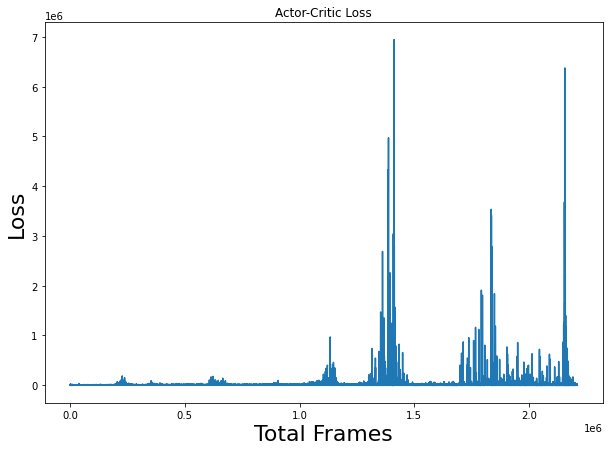

In [7]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Total Frames",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.title("Actor-Critic Loss")
plt.show()

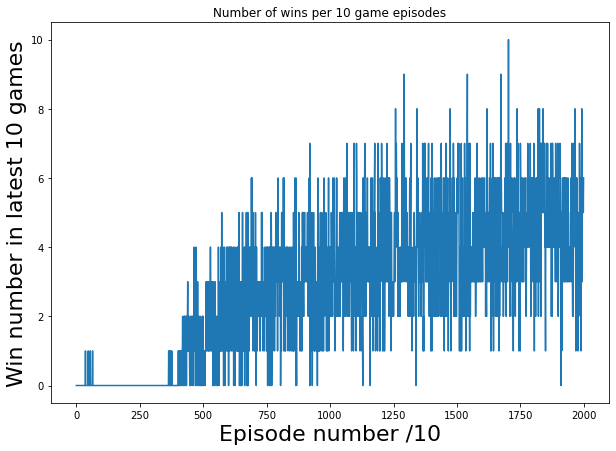

In [8]:
plt.figure(figsize=(10,7))
plt.plot(win_num_list)
plt.xlabel("Episode number /10",fontsize=22)
plt.ylabel("Win number in latest 10 games",fontsize=22)
plt.title("Number of wins per 10 game episodes")
plt.show()

In [9]:
actor_model.save_weights('model_actor_20000.h5')
critic_model.save_weights('model_critic_20000.h5')


## Testing

In [10]:
actor_model.load_weights('model_actor_20000.h5')
critic_model.load_weights('model_critic_20000.h5')

In [11]:
max_moves=250
def test_keras_model(actor_model, display=True):
    clear_output(wait=True)
    i = 0
    test_game = Environment().initialize(4,4,0.2,True)[0]
    goldinPW = 1. if test_game.goldlocation == test_game.wumpuslocation or (test_game.goldlocation in test_game.pitlocations) else 0.
    stuck = 0
    die = 0
    winnogold = 0

    
    state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
    if display:
        print("Initial State:")
        print(test_game.visualize())
    status = 1
    while(status == 1):
        qval_ = actor_model(state,training=False)
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.applyAction(action)
        state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
        if display:
            print(test_game.visualize())
        reward = test_game.agent.currentreward
        total_reward = test_game.agent.totalreward
        if test_game.terminated:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (test_game.agent.totalreward))
            else:
                if goldinPW and action=='Climb':
                    status = 2
                    winnogold += 1.
                    if display:
                        print("Game won! Reward: %s" % (test_game.agent.totalreward),"choose to climb out without gold")
                else:    
                    status = 0
                    die = 1
                    if display:
                        print("Game LOST. Reward: %s" % (test_game.agent.totalreward))
        i += 1
        if (i > max_moves):
            stuck=1
            if display:
                print("Game lost; too many moves.")
            break
   
    win = True if status == 2 else False
    pitnum = [0,0,0,0,0]
    win_in_pitnum = [0,0,0,0,0]
    num_of_pits = len(test_game.pitlocations)
    if num_of_pits == 0:
        pitnum[0]=1.
        if win:
            win_in_pitnum[0]=1.
    if num_of_pits == 1:
        pitnum[1]=1.
        if win:
            win_in_pitnum[1]=1.
    if num_of_pits == 2:
        pitnum[2]=1.
        if win:
            win_in_pitnum[2]=1.
    if num_of_pits == 3:
        pitnum[3]=1.
        if win:
            win_in_pitnum[3]=1.
    if num_of_pits >= 4:
        pitnum[4]=1.
        if win:
            win_in_pitnum[4]=1.
#     print("Reward:", test_game.agent.totalreward, win,action)
#     print(test_game.visualize())
    return win,total_reward,goldinPW,stuck,die,np.array(pitnum),np.array(win_in_pitnum),winnogold

In [12]:
# sample game
test_keras_model(actor_model,display=True)

Initial State:
    |G   |W   |P   
    |    |    |    
    |P   |    |    
A   |    |    |    

Move #: 0; Taking action: Forward
    |G   |W   |P   
    |    |    |    
    |P   |    |    
    |A   |    |    

Move #: 1; Taking action: Forward
    |G   |W   |P   
    |    |    |    
    |P   |    |    
    |    |A   |    

Move #: 2; Taking action: Forward
    |G   |W   |P   
    |    |    |    
    |P   |    |    
    |    |    |A   

Move #: 3; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |    
    |P   |    |    
    |    |    |A   

Move #: 4; Taking action: Forward
    |G   |W   |P   
    |    |    |    
    |P   |    |A   
    |    |    |    

Move #: 5; Taking action: Forward
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 6; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 7; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
  

Move #: 88; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 89; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 90; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 91; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 92; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 93; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 94; Taking action: Grab
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 95; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 96; Taking action: TurnLeft
    |G   |W   |P   
    |    |  


Move #: 183; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 184; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 185; Taking action: Grab
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 186; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 187; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 188; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 189; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 190; Taking action: TurnLeft
    |G   |W   |P   
    |    |    |A   
    |P   |    |    
    |    |    |    

Move #: 191; Taking action: TurnLeft
    |G   |W   |P   
  

(False,
 -261,
 0.0,
 1,
 0,
 array([0., 0., 1., 0., 0.]),
 array([0, 0, 0, 0, 0]),
 0)

In [13]:
max_games = 1000
wins = 0
reward = 0
goldinpwtotal = 0
stucktotal = 0
dietotal = 0
winnogoldtotal = 0
pitnumtotal = np.array([0,0,0,0,0])
winpitnumtotal = np.array([0,0,0,0,0])

for i in range(max_games):
    print('currently palying game:',i+1)
    win,treward,goldinpw,stuck,die,pitnum,winpitnum,winnogold = test_keras_model(
        actor_model, display=False)
    reward += treward
    goldinpwtotal += goldinpw
    dietotal += die
    stucktotal += stuck
    pitnumtotal = pitnumtotal+pitnum
    winpitnumtotal = winpitnumtotal + winpitnum
    winnogoldtotal += winnogold
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
avg_reward = reward/max_games
print("Games played: {0}, number of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
print("Average reward: {}".format(avg_reward))
print("Games with gold in pits/wumpus: {0}, win rate in other games: {1}".format(goldinpwtotal,wins/(max_games-goldinpwtotal)))
print("Games stuck: {}, games died: {}".format(stucktotal,dietotal))
print("Games with pits number 0,1,2,3 and 4+: {}, win numbers in those games: {}, win ratio: {}".format(pitnumtotal,
                                                                                                        winpitnumtotal,
                                                                                                        winpitnumtotal/pitnumtotal))
print("Climb out without gold: {}, ratio: {}".format(winnogoldtotal, winnogoldtotal/goldinpwtotal))

Games played: 1000, number of wins: 411
Win percentage: 41.099999999999994%
Average reward: 217.989
Games with gold in pits/wumpus: 310.0, win rate in other games: 0.5956521739130435
Games stuck: 545, games died: 44
Games with pits number 0,1,2,3 and 4+: [128. 300. 316. 174.  82.], win numbers in those games: [108. 152.  94.  43.  14.], win ratio: [0.84375    0.50666667 0.29746835 0.24712644 0.17073171]
Climb out without gold: 0, ratio: 0.0


Text(0, 0.5, 'Winning rate')

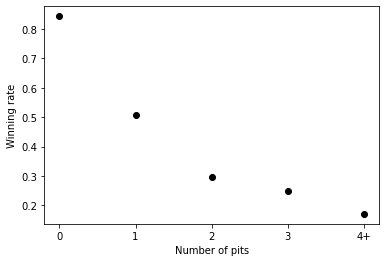

In [14]:
plt.plot(['0','1','2','3','4+'],winpitnumtotal/pitnumtotal, 'o', color='black')
plt.xlabel('Number of pits')
plt.ylabel('Winning rate')